In [1]:
%load_ext autoreload
import pandas as pd
from clustering_and_prim_tools import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data2day      = 30
year          = 2030
ini_year      = 2007

nameofthisround = 'sept2016_4'


In [4]:
countrycode="ETH"

In [5]:
forprim_bau = pd.read_csv(countrycode+"_bau.csv")

In [6]:
forprim_bau["scenar_id"] = forprim_bau.scenar.astype(str)+forprim_bau.ssp.astype(str)

In [7]:
forprim_bau.set_index("scenar_id",inplace=True)

In [8]:
def turn_pc(forprim,var):
    newcol = var+"pc"
    forprim[newcol] = forprim[var]/forprim["tot_pop"]
    return forprim

In [9]:
forprim_bau.columns

Index(['countryname', 'scenar', 'ssp', 'ccint', 'country', 'year', 'GDP',
       'avincome', 'incbott10', 'incbott20', 'inc2040', 'incbott40',
       'quintilecum1', 'quintilecum2', 'quintilepc1', 'quintilepc2',
       'belowpovline', 'below2', 'below4', 'below6', 'below8', 'below10',
       'gini', 'tot_pop', 'gappovline', 'gap2', 'gap4', 'gap6', 'gap8',
       'gap10', 'childrenag', 'childrenonag', 'peopleag', 'peoplenonag',
       'avincomeag', 'avincomenonag', 'shareag', 'sharemanu', 'shareemp',
       'grserv', 'grag', 'grmanu', 'skillpserv', 'skillpag', 'skillpmanu', 'p',
       'b', 'voice', 'prod_gr_ag', 'prod_gr_serv', 'prod_gr_manu', 'issp5'],
      dtype='object')

In [73]:
forprim_bau = forprim_bau.drop("ccint",axis=1).drop_duplicates()

In [10]:
forprim_bau = turn_pc(forprim_bau,"belowpovline")
forprim_bau = turn_pc(forprim_bau,"below2")
forprim_bau = turn_pc(forprim_bau,"below4")

In [11]:
ini_data = pd.read_csv("ini_data_info_may14.csv")
ini = ini_data.loc[ini_data.countrycode==countrycode,:]

In [12]:
forprim_bau["shprosp"] = forprim_bau.incbott40/forprim_bau.avincome
forprim_bau['shprosp_pc']=(forprim_bau['incbott40']/ini['incbott40'].values[0])**(1/(2030-2007))-(forprim_bau['avincome']/ini['avincome'].values[0])**(1/(2030-2007))

In [13]:
forprim_bau["incbott20"]=forprim_bau["incbott20"]/30

In [14]:
forprim_bau["isssp5"] = 0+(forprim_bau.ssp=="ssp5").astype(int)

In [15]:
outcomes_col = ['GDP', 'avincome','incbott20', 'inc2040', 'incbott40', 'belowpovline', 'belowpovlinepc','shprosp']
experiments_col = ['shareag', 'sharemanu', 'shareemp', 'grserv', 'grag','grmanu',\
                   'skillpserv', 'skillpag', 'skillpmanu', 'p', 'b','isssp5']

# analysis of variance to have an idea of the main drivers

## shared prosperity

In [16]:
drivers_from_anova("shprosp",forprim_bau,experiments_col)

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


(['skillpserv', 'b', 'grserv'], 0.69281115857786135)

skill premium in services, redistribution (basic income), productivity growth in services

## poverty

In [17]:
drivers_from_anova("incbott20",forprim_bau,experiments_col)

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


(['isssp5', 'b', 'grag'], 0.5689228335178782)

demography, redistribution, productivity growth in ag

# choose the two variables to study

In [19]:
data2="incbott20"
data1="shprosp_pc"

# define optimistic and pessimistic as in the shockwaves report

In [20]:
def optandpess(data,varpoors,varineq,thlist):
  th1=find_median(data,varpoors,thlist)
  th2=find_median(data,varineq,thlist)
  if varpoors=="incbott20":
    opt=(data.loc[:,varineq]>th2[1])&(data.loc[:,varpoors]>th1[1])
    pess=(data.loc[:,varineq]<th2[0])&(data.loc[:,varpoors]<th1[0])
  else:
    opt=(data.loc[:,varineq]>th2[1])&(data.loc[:,varpoors]<th1[0])
    pess=(data.loc[:,varineq]<th2[0])&(data.loc[:,varpoors]>th1[1])
  return opt,pess

In [21]:
def find_median(data,variable,thlist):
    var=data[variable]
    out=np.percentile(var,thlist)
    return out

In [42]:
opt,pess=optandpess(forprim_bau,data2,data1,[50,50])

In [43]:
import seaborn as sns
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [44]:
def plotgroup(outcomes,data1,data2,group,thelabel,thecolor,xy,ang=40):
    plt.scatter(outcomes.ix[group,data1],outcomes.ix[group,data2],marker='x',facecolors=thecolor, edgecolors=thecolor,s=6)
    plt.annotate(thelabel, xy=(np.mean(outcomes.ix[group,data1]), np.mean(outcomes.ix[group,data2])),  xycoords='data',
                    xytext=xy, textcoords='offset points',
                    size=15,
                    #bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    fc=thecolor, ec=thecolor,
                                    patchB=None,alpha=0.4,
                                    connectionstyle="angle3,angleA=0,angleB={}".format(ang)),
                        )
    

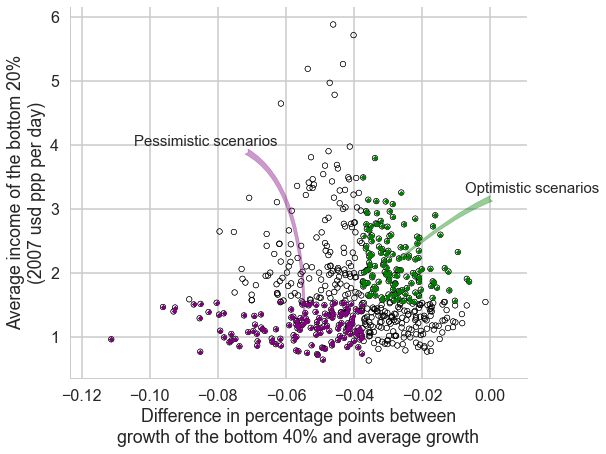

In [45]:
plt.figure(figsize=(18,15))
ax1=plt.subplot(222)
plt.scatter(forprim_bau[data1],forprim_bau[data2],marker='o',facecolors='none', edgecolors='black',s=30)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.margins(0.05)
plt.ylabel("Average income of the bottom 20%\n(2007 usd ppp per day)")
plt.xlabel("Difference in percentage points between\ngrowth of the bottom 40% and average growth")
plotgroup(forprim_bau,data1,data2,opt,"Optimistic scenarios","green",(70,70))
plotgroup(forprim_bau,data1,data2,pess,"Pessimistic scenarios","purple",(-170,180),ang=-90)
#plt.savefig(countrycode+"optandpess.png",bbox_inches="tight",dpi=300)

In [46]:
forprim_bau["opt"]=opt+0
forprim_bau["pess"]=pess+0

# run prim for the optimistic scenario

In [47]:
p = prim.Prim(forprim_bau[experiments_col].reset_index().drop("scenar_id",axis=1),\
              forprim_bau.opt, threshold=0.5, threshold_type=">")

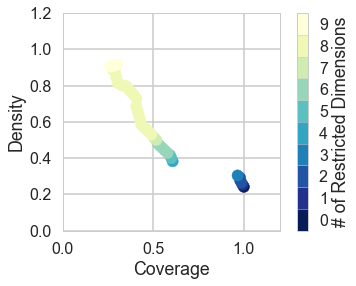

In [48]:
box = p.find_box()
box.show_tradeoff();

In [49]:
box.select(15)
print(box.coverage,box.density)
print(box.limits)

0.503448275862 0.514084507042
                 min       max     qp values
isssp5      1.000000  1.000000  1.363339e-07
b           0.037657  0.199867  2.475321e-03
skillpserv  1.007377  4.192823  1.282639e-02
grmanu     -0.010818  0.042850  8.521166e-02
sharemanu   0.116583  0.260226  1.454738e-01
grserv     -0.013595  0.044214  2.610304e-01
grag       -0.010405  0.046132  4.256950e-01


### min and max for each uncertain variable (for comparison)

In [54]:
forprim_bau[experiments_col].describe().loc[['min','max'],:]

,shareag,sharemanu,shareemp,grserv,grag,grmanu,skillpserv,skillpag,skillpmanu,p,b,isssp5
min,0.346972,0.101577,0.682724,-0.013595,-0.013726,-0.013619,1.007377,1.007767,1.005977,0.001581,0.001431,0.0
max,0.698680,0.260226,0.902759,0.046104,0.046132,0.046132,4.988608,4.997463,4.989220,0.199411,0.199867,1.0


Only 50/50 coverage and density. main driver is demography (ssp 5), relatively high redistribution (>4%), skill premium no higher than 4.2 in services

# run prim for the pessimistic scenario

In [50]:
p2 = prim.Prim(forprim_bau[experiments_col].reset_index().drop("scenar_id",axis=1),\
              forprim_bau.pess, threshold=0.5, threshold_type=">")

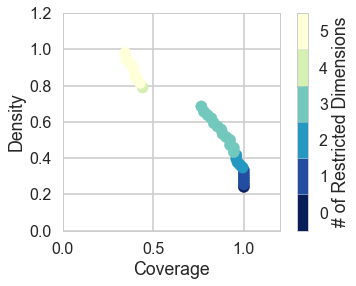

In [51]:
box2 = p2.find_box()
box2.show_tradeoff();

In [52]:
box2.select(22)
print(box2.coverage,box2.density)
print(box2.limits)

0.8 0.637362637363
                 min       max     qp values
b           0.001431  0.104115  1.124562e-22
grag       -0.013726  0.025349  1.218273e-10
skillpserv  1.619065  4.988608  4.736873e-02


redistribution lower than 10%, growth in ag lower than 2.5%, skill premium in services higher than 1.6

# run the clustering

In [33]:
oois = [data1,data2]

data = np.array([[forprim_bau[oois[0]][0],forprim_bau[oois[1]][0]]])
for i in range(1,len(forprim_bau.index)):
    data = np.concatenate((data,np.array([[forprim_bau[oois[0]][i],forprim_bau[oois[1]][i]]])))

data_norm = normalize(data)

In [34]:
n_clusters = 4
f_value = 0.5
seuil = 1.2

In [35]:
inputs = forprim_bau[experiments_col].reset_index().drop("scenar_id",axis=1)

In [55]:
while n_clusters>2:

    condition = True

    for i in get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs,data_norm)[0]:
        if i.coverage+i.density < seuil:
            condition = False
        else:
            condition = condition&True
    if condition == True:
        break
    else:
        n_clusters = n_clusters - 1
        continue


#Plot of clusters


dummy = get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs,data_norm)
boxes = dummy[0]
df = dummy[1]

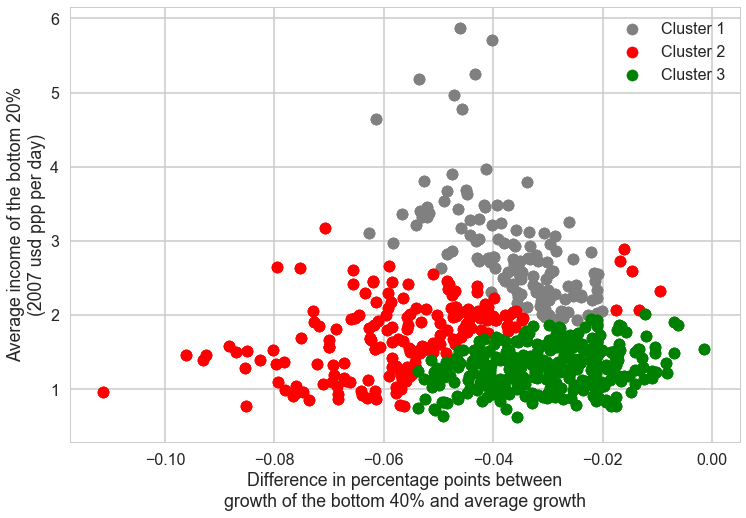

In [56]:
plt.figure(figsize=(12,8))

mycolors = ["grey","red","green","blue"]
for (i,subdf) in df.groupby("class"):

    plt.scatter(subdf[data1],subdf[data2],label="Cluster {}".format(i),c=mycolors[i-1])
plt.legend()
plt.ylabel("Average income of the bottom 20%\n(2007 usd ppp per day)")
plt.xlabel("Difference in percentage points between\ngrowth of the bottom 40% and average growth")

note that cluster 2 has some scenarios that manage to go to the right side of the graph. weird

In [67]:
df.loc[(df["class"]==2)&(df.shprosp_pc>(-0.02)),:]

,shprosp_pc,incbott20,class
174,-0.013372,2.071918,2
175,-0.013372,2.071918,2
702,-0.016816,2.724451,2
703,-0.016816,2.724451,2
764,-0.017574,2.062184,2
765,-0.017574,2.062184,2
906,-0.014651,2.594653,2
907,-0.014651,2.594653,2
1002,-0.016163,2.897499,2
1003,-0.016163,2.897499,2


In [75]:
forprim_bau.loc[(forprim_bau.shprosp_pc>(-0.018))&(forprim_bau.shprosp_pc<(-0.0001))&(forprim_bau.incbott20>2.05)&(forprim_bau.incbott20<2.9),experiments_col]

,shareag,sharemanu,shareemp,grserv,grag,grmanu,skillpserv,skillpag,skillpmanu,p,b,isssp5
scenar_id,,,,,,,,,,,,
43ssp5,0.386051,0.180831,0.809291,-0.009303,0.036237,0.015945,1.620802,2.222605,3.675816,0.073880,0.178567,1
175ssp5,0.499088,0.209817,0.749527,-0.007300,0.044327,0.037193,2.956582,1.863771,1.248419,0.117111,0.196490,1
191ssp4,0.364162,0.130219,0.868365,0.020186,0.044819,0.041755,1.946737,4.426095,3.307118,0.066939,0.140063,0
226ssp5,0.615792,0.139975,0.736631,-0.002038,0.045634,0.024080,2.127036,3.196215,2.591669,0.098488,0.176232,1
250ssp5,0.689273,0.188507,0.791112,0.002803,0.040814,0.039558,3.606776,4.536557,1.353080,0.023772,0.133281,1
274ssp5,0.488496,0.166865,0.879322,-0.001932,0.043973,0.038615,1.192236,1.535880,1.766706,0.190284,0.146764,1


## show prim results for the clusters

### min and max for each uncertain variable (for comparison)

In [53]:
forprim_bau[experiments_col].describe().loc[['min','max'],:]

,shareag,sharemanu,shareemp,grserv,grag,grmanu,skillpserv,skillpag,skillpmanu,p,b,isssp5
min,0.346972,0.101577,0.682724,-0.013595,-0.013726,-0.013619,1.007377,1.007767,1.005977,0.001581,0.001431,0.0
max,0.698680,0.260226,0.902759,0.046104,0.046132,0.046132,4.988608,4.997463,4.989220,0.199411,0.199867,1.0


### low poverty scenario (cluster 1)

In [57]:
boxes[0].limits

,min,max,qp values
isssp5,1.000000,1.000000,3.463088e-23
b,0.091332,0.199867,8.420967e-22
skillpag,1.351158,4.761411,2.113920e-02
grag,-0.010573,0.046132,1.343312e-01
grmanu,-0.010610,0.046132,2.628832e-01


### pessimistic scenario (cluster 2)

In [58]:
boxes[1].limits

,min,max,qp values
isssp5,1.000000,1.000000,4.853617e-11
skillpserv,1.758578,4.988608,9.756227e-04
b,0.001431,0.168534,8.336780e-03
grserv,-0.007256,0.046104,7.496939e-02
p,0.012126,0.199411,2.138123e-01


### high poverty/low inequality scenario (cluster 3)

In [59]:
boxes[2].limits

,min,max,qp values
isssp5,0.0,0.0,1.915169e-45


interestingly, the cluster in the far right bottom (high poverty/low inequality) is mostly driven by the population of SSP4....